In [71]:
import math
import time
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

In [72]:
epochs = 100
device = torch.device("cpu")

eps1 = 1
eps2 = 1

learning_rate = 1e-3
batchflag = True
batchsize = 32

start = 0.
end = 1.
x = np.linspace(start,end,100)
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))

def actual_soln():
    l1 = np.sqrt(1 + 16*eps1/eps2) - 1
    l2 = np.sqrt(1 + 16*eps1/eps2) + 1
    return 0.25*(1 - np.exp(-eps2*l1*x/2*eps1))*(1 - np.exp(-eps2*l2*(1-x)/2*eps1))*(1 - np.exp(-y/np.sqrt(eps1)))*(1 - np.exp(-(1-y)/np.sqrt(eps1)))


In [73]:

def plot_graph(soln,soln_name):
    x = np.linspace(start,end,100);t = np.linspace(start,end,100)
    x,t = np.meshgrid(x,t)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x,t,soln.reshape(100,100))
    plt.title(soln_name)
    plt.show()

class Swish(nn.Module):
	def __init__(self, inplace=True):
		super(Swish, self).__init__()
		self.inplace = inplace

	def forward(self, x):
		if self.inplace:
			x.mul_(torch.sigmoid(x))
			return x
		else:
			return x * torch.sigmoid(x)
	

class FBPINN(nn.Module):
	hid_dim = 128
	input_dim = 2 
	def __init__(self):
		super(FBPINN, self).__init__()
		self.tanh = nn.Tanh()
		self.lin0 = nn.Linear(self.input_dim,self.hid_dim)
		self.lin = nn.Linear(self.hid_dim,self.hid_dim)
		self.lin1 = nn.Linear(self.hid_dim,1)
		self.swish = Swish()
	def forward(self,x):		
		tanh1 = self.tanh(x)
		tanh2 = self.tanh(1 - x)
		tanh11 = (tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))
		tanh22 = (tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))
		u = self.lin0(x)
		u = self.swish(u)
		u = self.lin(u)
		u = self.swish(u)
		u = self.lin(u)
		u = self.swish(u)
		u = self.lin(u)
		u = self.swish(u)
		u = self.lin1(u)
		#out = x*y*(1-x)*(1-y)*u
		out = u*tanh11*tanh22
		return out

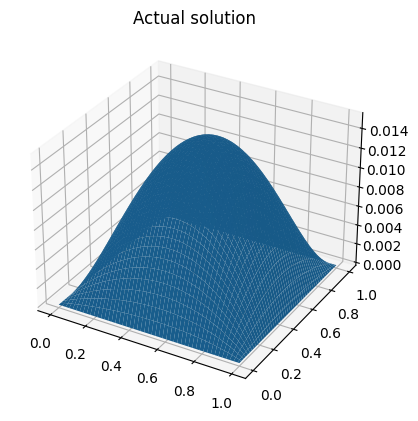

In [74]:
plot_graph(actual_soln(),"Actual solution")

In [75]:


def train(device,x,y,eps1,eps2,learning_rate,epochs,batch_flag,batch_size):
	
	xnet = torch.Tensor(x)
	ynet = torch.Tensor(y) 
	
	if(batch_flag):
		dataset = TensorDataset(xnet,ynet)
		dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers = 0,drop_last = True )
		#print(len(dataloader))
		
	net = FBPINN()
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,ynet):
		xnet.requires_grad = True
		ynet.requires_grad = True
		points = torch.cat((xnet,ynet),1) 
		U = net(points)
		U = U.view(len(U),-1)
				
		l1 = np.sqrt(1 + 16*eps1/eps2) - 1
		l2 = np.sqrt(1 + 16*eps1/eps2) + 1

		soln = 0.25*(1 - torch.exp(-eps2*l1*xnet/2*eps1))*(1 - torch.exp(-eps2*l2*(1-xnet)/2*eps1))*(1 - torch.exp(-ynet/np.sqrt(eps1)))*(1 - torch.exp(-(1-ynet)/np.sqrt(eps1)))

		soln_x = torch.autograd.grad(soln,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xx = torch.autograd.grad(soln_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_y = torch.autograd.grad(soln,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yy = torch.autograd.grad(soln_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]

		f = - eps1*(soln_yy + soln_xx) + (eps2)*(soln_x) + soln

		U_x = torch.autograd.grad(U,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]

		loss = -eps1*(U_yy + U_xx)+ (eps2)*(U_x) + U - f 
		
		return nn.MSELoss()(loss,torch.zeros_like(loss)) 

	losses = []
	tic = time.time()

	if(batch_flag):
		for epoch in range(epochs):
			if epoch == 10:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			for batch_idx, (x_in,y_in) in enumerate(dataloader):
				net.zero_grad()
				loss = Loss_criterion(x_in,y_in)
				loss.backward()

				optimizer.step() 
				if batch_idx % 20 ==0:
					print('Train Epoch: {} \tLoss: {:.20f}'.format(epoch, loss.item()))

			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln() - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.20f}\n'.format(
				epoch, actual_loss))
			if epoch % 1 == 0:
				plot_graph(z,'Predicted solution')
			
			losses.append(loss.item())

	else:
		for epoch in range(epochs):
			if epoch == 5:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
		
			net.zero_grad()
			loss = Loss_criterion(xnet,ynet)
			loss.backward()
			
			optimizer.step() 
			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			if epoch % 5 == 0:
				plot_graph(z,'Predicted solution')
			
			losses.append(loss.item())

	toc = time.time()
	elapseTime = toc - tic
	print ("Time elapsed = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output,losses 

Train Epoch: 0 	Loss: 0.02726651728153228760
Train Epoch: 0 	Loss: 0.00053104356629773974
Train Epoch: 0 	Loss: 0.00009504627814749256
Train Epoch: 0 	Loss: 0.00006607011891901493
Train Epoch: 0 	Loss: 0.00002659336678334512
Train Epoch: 0 	Loss: 0.00002226105243607890
Train Epoch: 0 	Loss: 0.00002739635237958282
Train Epoch: 0 	Loss: 0.00001671444078965578
Train Epoch: 0 	Loss: 0.00000878675837157061
Train Epoch: 0 	Loss: 0.00001005053309199866
Train Epoch: 0 	Loss: 0.00000587388512940379
Train Epoch: 0 	Loss: 0.00000211607493838528
Train Epoch: 0 	Loss: 0.00000554421603737865
Train Epoch: 0 	Loss: 0.00000406113485951209
Train Epoch: 0 	Loss: 0.00000235829179473512
Train Epoch: 0 	Loss: 0.00000875630121299764

After Epoch 0, 	 Actual solution loss: 0.00000007182300609261



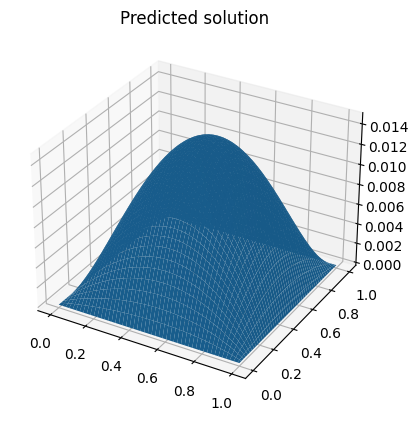

Train Epoch: 1 	Loss: 0.00004034243465866894
Train Epoch: 1 	Loss: 0.00003777335587074049
Train Epoch: 1 	Loss: 0.00003874103276757523
Train Epoch: 1 	Loss: 0.00004885027738055214
Train Epoch: 1 	Loss: 0.00001540968332847115
Train Epoch: 1 	Loss: 0.00000853458459459944
Train Epoch: 1 	Loss: 0.00009015278192237020
Train Epoch: 1 	Loss: 0.00002158604002033826
Train Epoch: 1 	Loss: 0.00001133183559431927
Train Epoch: 1 	Loss: 0.00005894364949199371
Train Epoch: 1 	Loss: 0.00001224910283781355
Train Epoch: 1 	Loss: 0.00002183939614042174
Train Epoch: 1 	Loss: 0.00002357517041673418
Train Epoch: 1 	Loss: 0.00000367793427358265
Train Epoch: 1 	Loss: 0.00001358207282464718
Train Epoch: 1 	Loss: 0.00001964461807801854

After Epoch 1, 	 Actual solution loss: 0.00000000983619657895



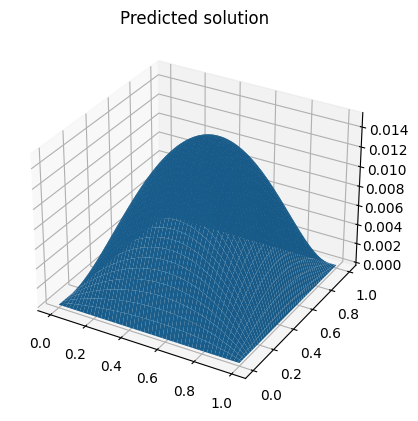

Train Epoch: 2 	Loss: 0.00001572325709275901
Train Epoch: 2 	Loss: 0.00002118162046826910
Train Epoch: 2 	Loss: 0.00001390179750160314
Train Epoch: 2 	Loss: 0.00000607375159233925


In [76]:
output,losses = train(device,x,y,eps1,eps2,learning_rate,epochs,batchflag,batchsize)

In [ ]:
z = output.detach().numpy()
plot_graph(z,"Predicted Solution")
plot_graph(actual_soln(eps),"Actual Solution")

In [ ]:
plt.plot(losses)
plt.show()